In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

from collections import namedtuple, deque
from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

SEED = 90

## Set Environment

In [7]:
env = UnityEnvironment(file_name='./Banana.app')

brain_name = env.brain_names[0] # get the brain from unity environment
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
print('Environment Info')
env_info = env.reset(train_mode=False)[brain_name] # reset environment to a new, random state
state = env_info.vector_observations[0] 
action_size = brain.vector_action_space_size

print('Number of agents: {}'.format(len(env_info.agents)))
print('State space: {}'.format(len(state)))
print('Action space: {}'.format(action_size))

Environment Info
Number of agents: 1
State space: 37
Action space: 4


## 🎬 Watch The Agent

In [9]:
total_score = []
num_episodes = 20

for i in range(1, num_episodes+1):
    
    score = 0
    print(f'Watching episode {i}...', end='')
    
    while True:
                
        action = np.random.randint(action_size)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        
        if done:
            clear_output(wait=True)
            
            total_score.append(score)
            env.reset()
            break

print('Watching finished.')
print('Average score for {} episodes: {}'.format(num_episodes, np.mean(total_score)))

Watching finished.
Average score for 20 episodes: -0.15


## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fc1_units)
        self.fc2_layer = nn.Linear(fc1_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        x = F.relu(self.fc1_layer(state))
        x = F.relu(self.fc2_layer(x))
        Qsa = self.fc3_layer(x)
        
        return Qsa

## Set Replay Buffer

In [11]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define DQN Agent

In [12]:
class DQNAgent(object):
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # init Q-Network & target network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        
        # init optimizer
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR) 
        
        # init Replay Buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
        
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
                
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get max predicted Q values (for next states) from target network
        Qsa_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q target
        Q_target = rewards + (gamma * Qsa_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update model parametes."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)
            
    def act(self, state, eps=0.):
        """Return actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
            
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def save(self, agent_location):
        torch.save(agent.dqn_net.state_dict(), agent_location)

    def load(self, agent_location):
        agent.dqn_net.load_state_dict(torch.load(agent_location))

In [13]:
agent = DQNAgent(state_size=len(state), action_size=action_size, seed=SEED)

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_target = 13.0
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        
        env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            agent.save(f'./agents/DQN_{brain_name}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 1.20
Episode: 200, Average Score: 4.53
Episode: 300, Average Score: 7.43
Episode: 400, Average Score: 11.21
Episode: 490, Average Score: 13.00
Environment solved in 390 episodes! Average Score: 13.00
Episode: 491, Average Score: 13.02
Environment solved in 391 episodes! Average Score: 13.02
Episode: 492, Average Score: 13.12
Environment solved in 392 episodes! Average Score: 13.12
Episode: 493, Average Score: 13.12
Environment solved in 393 episodes! Average Score: 13.12
Episode: 494, Average Score: 13.15
Environment solved in 394 episodes! Average Score: 13.15
Episode: 495, Average Score: 13.11
Environment solved in 395 episodes! Average Score: 13.11
Episode: 496, Average Score: 13.08
Environment solved in 396 episodes! Average Score: 13.08
Episode: 497, Average Score: 13.04
Environment solved in 397 episodes! Average Score: 13.04
Episode: 498, Average Score: 13.03
Environment solved in 398 episodes! Average Score: 13.03
Episode: 499, Average Score: 13.00


Episode: 581, Average Score: 14.28
Environment solved in 481 episodes! Average Score: 14.28
Episode: 582, Average Score: 14.24
Environment solved in 482 episodes! Average Score: 14.24
Episode: 583, Average Score: 14.26
Environment solved in 483 episodes! Average Score: 14.26
Episode: 584, Average Score: 14.18
Environment solved in 484 episodes! Average Score: 14.18
Episode: 585, Average Score: 14.28
Environment solved in 485 episodes! Average Score: 14.28
Episode: 586, Average Score: 14.27
Environment solved in 486 episodes! Average Score: 14.27
Episode: 587, Average Score: 14.24
Environment solved in 487 episodes! Average Score: 14.24
Episode: 588, Average Score: 14.24
Environment solved in 488 episodes! Average Score: 14.24
Episode: 589, Average Score: 14.21
Environment solved in 489 episodes! Average Score: 14.21
Episode: 590, Average Score: 14.22
Environment solved in 490 episodes! Average Score: 14.22
Episode: 591, Average Score: 14.29
Environment solved in 491 episodes! Average S

Episode: 671, Average Score: 15.18
Environment solved in 571 episodes! Average Score: 15.18
Episode: 672, Average Score: 15.20
Environment solved in 572 episodes! Average Score: 15.20
Episode: 673, Average Score: 15.17
Environment solved in 573 episodes! Average Score: 15.17
Episode: 674, Average Score: 15.22
Environment solved in 574 episodes! Average Score: 15.22
Episode: 675, Average Score: 15.17
Environment solved in 575 episodes! Average Score: 15.17
Episode: 676, Average Score: 15.14
Environment solved in 576 episodes! Average Score: 15.14
Episode: 677, Average Score: 15.14
Environment solved in 577 episodes! Average Score: 15.14
Episode: 678, Average Score: 15.17
Environment solved in 578 episodes! Average Score: 15.17
Episode: 679, Average Score: 15.09
Environment solved in 579 episodes! Average Score: 15.09
Episode: 680, Average Score: 15.01
Environment solved in 580 episodes! Average Score: 15.01
Episode: 681, Average Score: 14.99
Environment solved in 581 episodes! Average S

Episode: 761, Average Score: 14.49
Environment solved in 661 episodes! Average Score: 14.49
Episode: 762, Average Score: 14.46
Environment solved in 662 episodes! Average Score: 14.46
Episode: 763, Average Score: 14.55
Environment solved in 663 episodes! Average Score: 14.55
Episode: 764, Average Score: 14.53
Environment solved in 664 episodes! Average Score: 14.53
Episode: 765, Average Score: 14.50
Environment solved in 665 episodes! Average Score: 14.50
Episode: 766, Average Score: 14.53
Environment solved in 666 episodes! Average Score: 14.53
Episode: 767, Average Score: 14.57
Environment solved in 667 episodes! Average Score: 14.57
Episode: 768, Average Score: 14.60
Environment solved in 668 episodes! Average Score: 14.60
Episode: 769, Average Score: 14.60
Environment solved in 669 episodes! Average Score: 14.60
Episode: 770, Average Score: 14.65
Environment solved in 670 episodes! Average Score: 14.65
Episode: 771, Average Score: 14.50
Environment solved in 671 episodes! Average S

Episode: 851, Average Score: 15.57
Environment solved in 751 episodes! Average Score: 15.57
Episode: 852, Average Score: 15.63
Environment solved in 752 episodes! Average Score: 15.63
Episode: 853, Average Score: 15.59
Environment solved in 753 episodes! Average Score: 15.59
Episode: 854, Average Score: 15.62
Environment solved in 754 episodes! Average Score: 15.62
Episode: 855, Average Score: 15.59
Environment solved in 755 episodes! Average Score: 15.59
Episode: 856, Average Score: 15.62
Environment solved in 756 episodes! Average Score: 15.62
Episode: 857, Average Score: 15.69
Environment solved in 757 episodes! Average Score: 15.69
Episode: 858, Average Score: 15.69
Environment solved in 758 episodes! Average Score: 15.69
Episode: 859, Average Score: 15.63
Environment solved in 759 episodes! Average Score: 15.63
Episode: 860, Average Score: 15.63
Environment solved in 760 episodes! Average Score: 15.63
Episode: 861, Average Score: 15.65
Environment solved in 761 episodes! Average S

Episode: 941, Average Score: 15.43
Environment solved in 841 episodes! Average Score: 15.43
Episode: 942, Average Score: 15.45
Environment solved in 842 episodes! Average Score: 15.45
Episode: 943, Average Score: 15.44
Environment solved in 843 episodes! Average Score: 15.44
Episode: 944, Average Score: 15.47
Environment solved in 844 episodes! Average Score: 15.47
Episode: 945, Average Score: 15.47
Environment solved in 845 episodes! Average Score: 15.47
Episode: 946, Average Score: 15.47
Environment solved in 846 episodes! Average Score: 15.47
Episode: 947, Average Score: 15.46
Environment solved in 847 episodes! Average Score: 15.46
Episode: 948, Average Score: 15.36
Environment solved in 848 episodes! Average Score: 15.36
Episode: 949, Average Score: 15.38
Environment solved in 849 episodes! Average Score: 15.38
Episode: 950, Average Score: 15.47
Environment solved in 850 episodes! Average Score: 15.47
Episode: 951, Average Score: 15.47
Environment solved in 851 episodes! Average S

## Evaluate The Agent

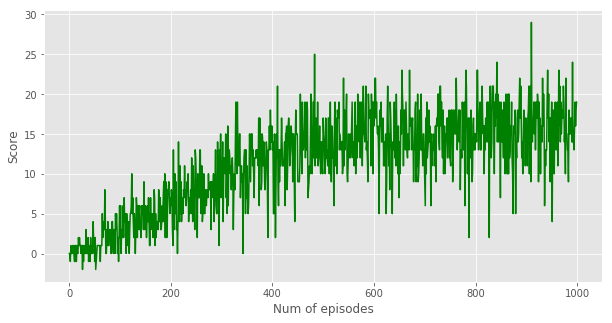

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
agent.load(f'./agents/DQN_{brain_name}.pth')

In [ ]:
total_score = []
num_episodes = 1

for i in range(1, num_episodes+1):
    
    score = 0
    print(f'Wgatching episode {i}...', end='')
    
    env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations
    
    while True:
                
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        
        if done:
            clear_output(wait=True)
            
            total_score.append(score)
            env.reset()
            break

print('Watching finished.')
print('Average score for {} episodes: {}'.format(num_episodes, np.mean(total_score)))

Watching episode 1...

---